### LSB steganography method

In [4]:
### LSB Encryption method

import numpy as np 
import random 
  
# Encryption function 
def encrypt(cover, secret, output): 
      
    # img1 and img2 are the 
    # two input images 
    img1 = cv2.imread(cover) 
    img2 = cv2.imread(secret) 
      
    for i in range(img2.shape[0]): 
        for j in range(img2.shape[1]): 
            for l in range(3): 
                  
                # v1 and v2 are 8-bit pixel values 
                # of img1 and img2 respectively 
                v1 = format(img1[i][j][l], '08b') 
                v2 = format(img2[i][j][l], '08b') 
                  
                # Taking 4 MSBs of each image 
                v3 = v1[:4] + v2[:4]  
                  
                img1[i][j][l]= int(v3, 2) 
                  
    cv2.imwrite(output, img1) 
  
      
# Decryption function 
def decrypt(inp, out1, out2): 
      
    # Encrypted image 
    img = cv2.imread(inp)  
    width = img.shape[0] 
    height = img.shape[1] 
      
    # img1 and img2 are two blank images 
    img1 = np.zeros((width, height, 3), np.uint8) 
    img2 = np.zeros((width, height, 3), np.uint8) 
      
    for i in range(width): 
        for j in range(height): 
            for l in range(3): 
                v1 = format(img[i][j][l], '08b') 
                v2 = v1[:4] + chr(random.randint(0, 1)+48) * 4
                v3 = v1[4:] + chr(random.randint(0, 1)+48) * 4
                  
                # Appending data to img1 and img2 
                img1[i][j][l]= int(v2, 2) 
                img2[i][j][l]= int(v3, 2) 
      
    # These are two images produced from 
    # the encrypted image 
    cv2.imwrite(out1, img1) 
    cv2.imwrite(out2, img2) 

In [5]:
# Test encryption
encrypt('test.jpg', 'secret.png', 'out.png') 

In [ ]:
# Test decryption
decrypt('out.png', 're.png', 'im.png') 

### Image DSP analysis

In [2]:
### DFT analysis
# DSP Library for python
import scipy.signal as dsp
import scipy.fft as transform
import matplotlib.pyplot as plt
import numpy as np 
import cv2

In [3]:
%matplotlib inline

In [4]:
test = cv2.imread('grumpy.jpg') 
# Image in BGR mode
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test.shape

(540, 960, 3)

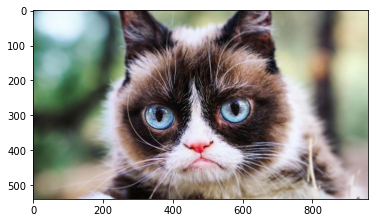

In [5]:
plt.imshow(test)

In [6]:
# Backup
cv2.imshow("test", test)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
freqs = transform.fft2(test)
freqs.shape

(540, 960, 3)

In [9]:
real = np.real(freqs)
#real = transform.fftshift(real)
real = transform.fftshift(real, axes=(0,1,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


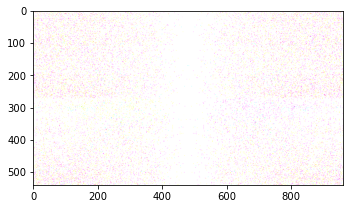

In [10]:
magnitude = 20*np.log(np.abs(real))
plt.figure(figsize=(6, 3.2))
plt.imshow(magnitude)

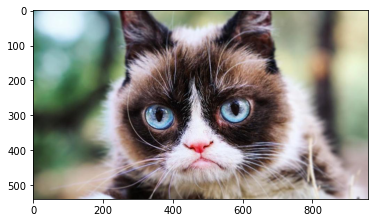

In [11]:
# Restoring image
restore = np.real(transform.ifft2(freqs))
# Converting double to 8 bits unsigned integer value
restore = restore.astype(np.uint8)
# Plotting
plt.imshow(restore)

In [12]:
(test-restore).mean()

0.2116943158436214

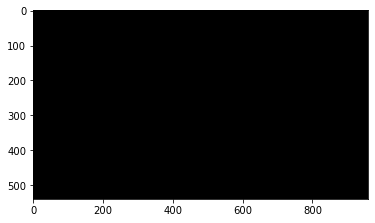

In [13]:
plt.imshow(test - restore)

In [14]:
save = cv2.cvtColor(restore, cv2.COLOR_RGB2BGR)
cv2.imwrite('ifft.jpg', save)

True

### Simple frequency domain convolve

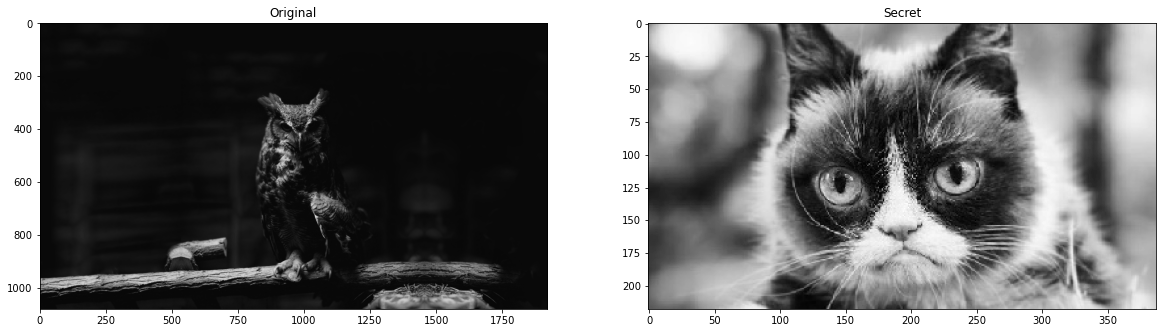

In [308]:
img1 = cv2.imread('test.jpg') 
img2 = cv2.imread('grumpy_compressed.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))

ax1.imshow(img1,cmap='gray')
ax1.set_title("Original")

ax2.imshow(img2,cmap='gray')
ax2.set_title("Secret")

plt.show()

In [309]:
### DFTIAT algorithm
# https://link.springer.com/content/pdf/10.1007%2F978-3-642-20998-7.pdf
# pp 336-341

def DFTIAT_GS_ENCODE(im_source, im_embed):
    image = im_source
    message = im_embed.flatten().tobytes()
    print(len(message))
    # Checking limiting parameter
    if (len(message) >= (image.shape[0]*image.shape[1]*3/4 - 16)): 
        raise Exception("Message could not be fitted into cover image")
    
    # word counter
    c = 0
    # bit counter
    b = 0
    # Sliding 2x2 Window of cover image
    for i in range (0,(image.shape[0]-3),2):
        for j in range (0,(image.shape[1]-3),2):
            # Taking 2x2 window
            window = image[i:i+2,j:j+2]
            # Process Fourier Transform and take the real part
            fd = transform.fft2(window)
            r = np.real(fd).flatten().astype(int)
            # Assign LSB to embedding image bit, skipping first freq component
            ## Gathering bits 
            bits = 0
            if(c < len(message)):
                if b <= 5:
                    # we do not need to select the next word
                    bits = (message[c]>>b)&0b00000111 #Take last 3 bits with shift by bit counter
                else:
                    # selecting next word
                    residual = 8 - b
                    bits = (message[c]>>b)&(2**residual-1) # Take residual part of the current value
                    if(c < len(message)-1):
                        c += 1 # Select next byte
                        b = residual # Assign residual part for next byte
                        bits += (message[c]>>b)&0b111 # Take part of the next value
                    else:
                        break
                b += 3
            ##
            # Setting bits
            for k in range(0,3,1):
                r[k+1] = (bits>>k)&1 # Assigning bit to the frequency tap
            # Taking inverse transform
            chunk = np.reshape(r, (-1, 2))
            image[i:i+2,j:j+2] = np.real(transform.ifft2(chunk))
    # Converting double to 8 bits unsigned integer value
    #res = image.astype(np.uint8)
    res = image
    return res

def DFTIAT_GS_DECODE(im_coded, height, width):
    image = im_coded
    # word counter
    c = 0
    # bit counter
    b = 0
    
    sequence = ""
    
    # Sliding 2x2 Window of cover image
    for i in range (0,(height-3),2):
        for j in range (0,(width-3),2):
            # Taking 2x2 window
            window = image[i:i+2,j:j+2]
            # Process Fourier Transform and take the real part
            fd = transform.fft2(window)
            r = np.real(fd).flatten().astype(int)
            # Take last 3 values
            for k in range(1,4,1):
                value = r[k]
                #Take LSB from freq response
                LSB = str(value&1)
                sequence += LSB
                r[k] = value^(1<<0)
            chunk = np.reshape(r, (-1, 2))
            image[i:i+2,j:j+2] = np.real(transform.ifft2(chunk))
    
    h = 0
    w = 0
    print(len(sequence))
    secret = np.empty([height, width])
    for i in range(0, len(sequence), 8):
        secret[h,w] = int(sequence[i:i+8],2)
        w += 1
        if w >= width - 1:
            h += 1
            w = 0
        if h >= height - 1:
            break
    # Converting double to 8 bits unsigned integer value
    #res = image.astype(np.uint8)
    #res = image
    return image, secret

In [310]:
x = DFTIAT_GS_ENCODE(img1,img2)

84366


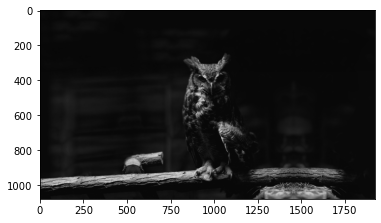

In [311]:
plt.imshow(x,cmap='gray')

In [312]:
cv2.imwrite('DFTIAT.jpg', x)

True

In [313]:
cv2.imwrite('gray.jpg', img1)

True

In [317]:
cover, secret = DFTIAT_GS_DECODE(x, img2.shape[0], img2.shape[1])

62208


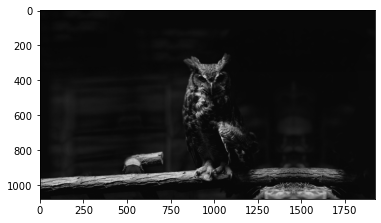

In [318]:
plt.imshow(cover,cmap='gray')

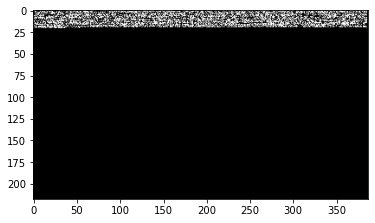

In [319]:
plt.imshow(secret,cmap='gray')

In [296]:
0b00010&1

0